# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
# import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
#     !touch .setup_complete

# # This code creates a virtual display to draw game images on.
# # It will have no effect if your machine has a monitor.
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

In [25]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.

In [4]:
def initialize_policy(n_states, n_actions):
    policy = np.full((n_states, n_actions), 1 / n_actions)
    
    return policy

policy = initialize_policy(n_states, n_actions)

In [5]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [55]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        # a = <YOUR CODE: sample action from policy>
        a = np.random.choice(n_actions, p = policy[s])

        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [7]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
# assert type(r) in [float, np.float]
assert type(r) == float

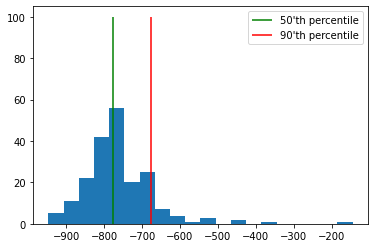

In [8]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps

In [9]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [i for i, j in zip(states_batch, rewards_batch) if j >= reward_threshold]
    elite_actions = [i for i, j in zip(actions_batch, rewards_batch) if j >= reward_threshold]

    ## Flatten list of lists to list
    elite_states = [item for sublist in elite_states for item in sublist]
    elite_actions = [item for sublist in elite_actions for item in sublist]

    return elite_states, elite_actions

In [10]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]), \
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]), \
    "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

Ok!


In [11]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    ## Remember which action we took in each state
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    
    ## Normalize actions across each state
    for i in range(n_states):
        rowsum = sum(new_policy[i])
        new_policy[i] = np.array(
            [new_policy[i] / rowsum if rowsum > 0 else np.ones(n_actions)/n_actions]
            )

    return new_policy

In [12]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(), \
    "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy >= 0), \
    "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1), 1), \
    "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [13]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [14]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)

mean reward = -65.612, threshold=4.500


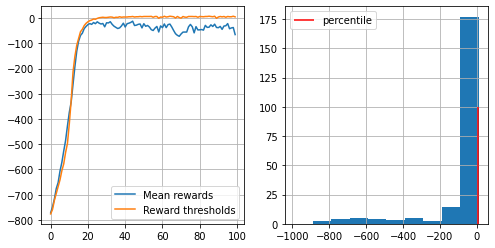

In [72]:
n_sessions = 250     # sample this many sessions
percentile = 50      # take this percent of session with highest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(100):
    # %time sessions = [ <YOUR CODE: generate a list of n_sessions new sessions> ]
    %time sessions = [generate_session(env, policy, t_max=1000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # elite_states, elite_actions = <YOUR CODE: select elite states & actions>
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    # new_policy = <YOUR CODE: compute new policy>
    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task

# Andrey Guryanov's comment! 
Перефразирую: проблема из-за того, что иногда попадаются начальные точки, из которых тачка категорически не хочет выезжать - и они будут постоянно откидываться, так как не будут попадать в элитные сессии. Грубо говоря, в 3/4 областей алгоритм научился выезжать, а на 1/4 поля просто забил - и никогда оттуда не выезжает.

Как пофиксить:
- Тюним параметры запуска!
  - Задираем трешхолд выше до 0.85 - так будем сходиться к самым выигрышным стратегиям
  - Выше трешхолд -> меньше сессий, попадающих в него. Поднимаем количество сессий до 1250 
  - При получении достаточно хорошей политики (средний реворд больше 5-7.5) начинаем снижать percentile и learning_rate
- Улучшаем и сам алгоритм
  - При запуске каждой сессии мы сыграем не одну, а N игр (лучший найденный N=50) из рандомных точек 
    - Саму карту при этом не нужно рандомить каждый раз, только начальное положение на ней
  - При старте каждой из 1250 сессий из текущей политики, которая строится на вероятностях, делаем детерминированную политику
    - Т.о. для каждого из 500 состояний берем ровно один экшен 
  - Каждый из N стартов первые M шагов (M=2) делаем по зафиксированной детерминированной политике
  - После этого продолжаем действовать согласно политике на вероятностях

In [67]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions, rewards = [], [], []
    
    fixed_policy = [np.random.choice(n_actions, p = policy[i]) for i in range(n_states)]
    s = env.reset()
    
    ## Пробовал разные значения, от 2 до 1000. Уже с 6 начинает очень медленно сходиться
    num_initial_steps = 2 # 3
    
    ## Пробовал значения от 1 до 10000 - на больших значениях опять же начинает очень медленно сходиться
    ## Если взять слишком мало игр (пример: 25), то средний реворд даже еле дотягивает до 0 и начнет падать
    num_games = 50 # 100

    for _ in range(num_games): # Number of games with fixed policy
        s = np.random.choice(n_states)
        current_reward = 0.

        ## Странный баг, при котором что исполнение сильно замедляется, 
        ## если сделать один цикл от 0 до t_max и проверять значение t
        ## для обхода временно делаю два цикла
        for _ in range(num_initial_steps):
            a = fixed_policy[s]
            new_s, r, done, info = env.step(a)

            # Record information we just got from the environment.
            states.append(s)
            actions.append(a)
            current_reward += r

            s = new_s
            if done:
                break

        if not done:
            for _ in range(t_max-num_initial_steps):
                a = np.random.choice(n_actions, p = policy[s])
                new_s, r, done, info = env.step(a)

                # Record information we just got from the environment.
                states.append(s)
                actions.append(a)
                current_reward += r

                s = new_s
                if done:
                    break

        rewards.append(current_reward)

    return states, actions, np.mean(rewards)

mean reward = 9.120, threshold=-22.175


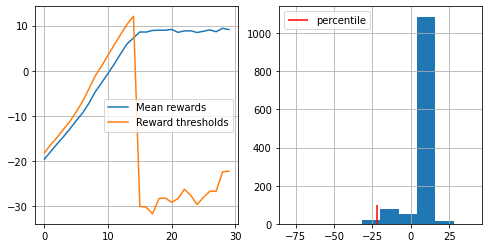

In [69]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)

n_sessions = 1250     # sample this many sessions
percentile = 85      # take this percent of session with highest rewards
learning_rate = 0.85  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(30):
    # %time sessions = [ <YOUR CODE: generate a list of n_sessions new sessions> ]
    sessions = [generate_session(env, policy, t_max=1000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    if np.mean(rewards_batch) > 7.5:
        percentile = 0.75
        learning_rate = 0.5

    # elite_states, elite_actions = <YOUR CODE: select elite states & actions>
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    # new_policy = <YOUR CODE: compute new policy>
    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile, reward_range=[-80, +40])

ToDo: 
- более плавный алгоритм по уменьшению percentile и learning_rate при входе в положительную зону

---
Если не уменьшать percentile и learning_rate - качество резко скатывается

mean reward = 5.596, threshold=17.580


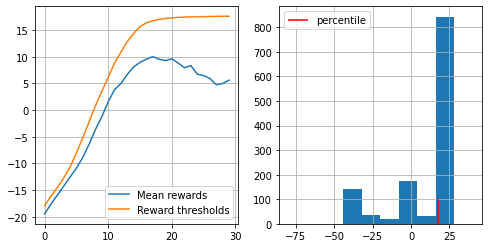

---
Проверим дефолтный генератор сессий

Если просто докинуть больше сессий и 85й перцентиль, то средний реворд не успеет даже дойти до 0 и сваливается вниз

mean reward = -363.879, threshold=11.000


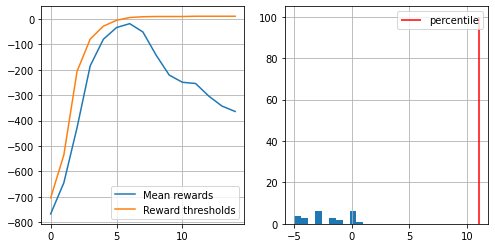